### --------------------------------------------------- MODELING USE LDA ---------------------------------------------------

***********************************
- Deskripsi : modelling dilakukan untuk bulan Agustus
- Data : data yang digunakan adalah data seluruh website, kecuali website seva
- Kategori : otomotif
- Tujuan : melihat topik apa yang banyak di bahas di bulan Agustus

***********************************

### import library

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from pprint import pprint
import os
from nltk import word_tokenize
import gensim.corpora as corpora
from gensim import corpora, models

# Set working directory first
cwd = os.getcwd()
os.chdir("D:\\OJT\\NLTK GRAM\\Modeling LDA")
import DataPreparation as dp
dp_obj = dp.DataPreparation()

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
# Import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\petron059243\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### load data

In [4]:
#--------LOAD DATA------------#
data = pd.read_pickle('Data/otomotif_januari.pkl')

In [3]:
data.head()

id   source             pubdate    month clean_category  category  \
1220  1222  gridoto 2018-01-01 19:20:34  january       otomotif  Otomotif   
1223  1225  gridoto 2018-01-01 19:07:16  january       otomotif  Otomotif   
1227  1229  gridoto 2018-01-01 18:45:00  january       otomotif  Otomotif   
1230  1232  gridoto 2018-01-01 18:40:00  january       otomotif  Otomotif   
1234  1236  gridoto 2018-01-01 18:30:00  january       otomotif  Otomotif   

     subcategory                                            content  \
1220        News  GridOto.com– Membeludaknya pengunjung Margasat...   
1223       Other  GridOto.com- Berbagai tren gaya berfoto tercip...   
1227        News  GridOto.com-Nissansudah lama terendus mengingi...   
1230        News  GridOto.com -Mencucui motor sebenarnya merupak...   
1234       Other  GridOto.com-Polisiseharusnya memang memilikisk...   

                                               content2  \
1220   beludak unjung margasatwa ragunanmenyebabkan ...   
1223   tren gaya foto cipta anak anak kreatif puji k...   
1227   nissansudah endus su vberbasis generasi pikap...   
1230   cucu motor giat tuju tampil motor bersih cucu...   
1234   polisiseharusnya memilikiskill berkendaradi o...   

                                              tokenized  \
1220  [beludak, unjung, margasatwa, ragunanmenyebabk...   
1223  [tren, gaya, foto, cipta, anak, anak, kreatif,...   
1227  [nissansudah, endus, su, vberbasis, generasi, ...   
1230  [cucu, motor, giat, tuju, tampil, motor, bersi...   
1234  [polisiseharusnya, memilikiskill, berkendaradi...   

      word_count_after_prep  avg_word_after_prep  count_word  
1220                    125             5.596774         115  
1223                     59             6.655172          52  
1227                     82             5.650000          78  
1230                     91             5.101124          89  
1234                     53             6.901961          51

In [4]:
data.shape

(10719, 13)

### corpus, dictionary, doc_term_matrix(BoW), TF-IDF

In [5]:
# membuat corpus 
corpus = data['tokenized'].tolist()

# membuat dictionary
dictionary = corpora.Dictionary(corpus)

# save dictionary ke folder Dictionary
dictionary.save("Dictionary/otomotif_januari.dict")

# membuat BoW (jumlah kata yang muncul disetiap dokumen)
corpus_bow = [dictionary.doc2bow(d) for d in corpus]

# membuat TF-IDF (menghitung pembobot, dihitung dari BoW)
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

2018-10-11 15:18:41,539 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-10-11 15:18:43,400 : INFO : adding document #10000 to Dictionary(54125 unique tokens: ['arah', 'baca', 'banyak', 'barat', 'basah']...)
2018-10-11 15:18:43,524 : INFO : built Dictionary(55571 unique tokens: ['arah', 'baca', 'banyak', 'barat', 'basah']...) from 10719 documents (total 1365736 corpus positions)
2018-10-11 15:18:43,525 : INFO : saving Dictionary object under Dictionary/otomotif_januari.dict, separately None
2018-10-11 15:18:43,557 : INFO : saved Dictionary/otomotif_januari.dict
2018-10-11 15:18:45,081 : INFO : collecting document frequencies
2018-10-11 15:18:45,082 : INFO : PROGRESS: processing document #0
2018-10-11 15:18:45,353 : INFO : PROGRESS: processing document #10000
2018-10-11 15:18:45,375 : INFO : calculating IDF weights for 10719 documents and 55570 features (874274 matrix non-zeros)


### ------------------------------------------------------ ITERATION ----------------------------------------------------------------------------

### def LDA model for automotive

- iterasi model terhadap banyaknya kluster topik, digunakan untuk menemukan topik dengan topic coherence dan perplexity yang optimal

In [6]:
def compute_coherence_values(dictionary, corpus, texts, random_state, chunksize, start, limit, step, workers):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state, chunksize=chunksize,workers=workers, per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts,coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

****Lda Multicore**** digunakan untuk mempercepat proses komputasi

In [7]:
start = 2
limit = 31
step = 2
random_state = 100
chunksize = 1000
workers = 3

In [8]:
# Can take a long time to run.
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_bow, texts=corpus, random_state=random_state, chunksize=chunksize, start=start, limit=limit, step=step, workers=workers)

2018-10-10 08:30:17,751 : INFO : using symmetric alpha at 0.5
2018-10-10 08:30:17,751 : INFO : using symmetric eta at 0.5
2018-10-10 08:30:17,771 : INFO : using serial LDA version on this node
2018-10-10 08:30:17,795 : INFO : running online LDA training, 2 topics, 1 passes over the supplied corpus of 10719 documents, updating every 3000 documents, evaluating every ~10719 documents, iterating 50x with a convergence threshold of 0.001000
2018-10-10 08:30:17,795 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-10-10 08:30:17,799 : INFO : training LDA model using 3 processes
2018-10-10 08:30:17,875 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/10719, outstanding queue size 1
2018-10-10 08:30:17,875 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/10719, outstanding queue size 2
2018-10-10 08:30:17,879 : INFO : PROGRESS: pass 0, dispatched chunk #2 = docume

2018-10-10 08:30:38,870 : INFO : 80 batches submitted to accumulate stats from 5120 documents (20853 virtual)
2018-10-10 08:30:38,878 : INFO : 81 batches submitted to accumulate stats from 5184 documents (21762 virtual)
2018-10-10 08:30:38,886 : INFO : 82 batches submitted to accumulate stats from 5248 documents (22339 virtual)
2018-10-10 08:30:38,942 : INFO : 83 batches submitted to accumulate stats from 5312 documents (26328 virtual)
2018-10-10 08:30:38,958 : INFO : 84 batches submitted to accumulate stats from 5376 documents (30231 virtual)
2018-10-10 08:30:38,966 : INFO : 85 batches submitted to accumulate stats from 5440 documents (37275 virtual)
2018-10-10 08:30:39,034 : INFO : 86 batches submitted to accumulate stats from 5504 documents (40075 virtual)
2018-10-10 08:30:39,062 : INFO : 87 batches submitted to accumulate stats from 5568 documents (42445 virtual)
2018-10-10 08:30:39,070 : INFO : 88 batches submitted to accumulate stats from 5632 documents (48491 virtual)
2018-10-10

2018-10-10 08:30:42,300 : INFO : 161 batches submitted to accumulate stats from 10304 documents (196297 virtual)
2018-10-10 08:30:42,308 : INFO : 162 batches submitted to accumulate stats from 10368 documents (197045 virtual)
2018-10-10 08:30:42,360 : INFO : 163 batches submitted to accumulate stats from 10432 documents (197671 virtual)
2018-10-10 08:30:42,380 : INFO : 164 batches submitted to accumulate stats from 10496 documents (198373 virtual)
2018-10-10 08:30:42,428 : INFO : 165 batches submitted to accumulate stats from 10560 documents (199369 virtual)
2018-10-10 08:30:42,464 : INFO : 166 batches submitted to accumulate stats from 10624 documents (199714 virtual)
2018-10-10 08:30:42,468 : INFO : 167 batches submitted to accumulate stats from 10688 documents (199964 virtual)
2018-10-10 08:30:42,771 : INFO : 3 accumulators retrieved from output queue
2018-10-10 08:30:42,805 : INFO : accumulated word occurrence stats for 349365 virtual documents
2018-10-10 08:30:42,931 : INFO : usin

2018-10-10 08:31:02,558 : INFO : 32 batches submitted to accumulate stats from 2048 documents (-7767 virtual)
2018-10-10 08:31:02,597 : INFO : 34 batches submitted to accumulate stats from 2176 documents (-8143 virtual)
2018-10-10 08:31:02,649 : INFO : 36 batches submitted to accumulate stats from 2304 documents (-7949 virtual)
2018-10-10 08:31:02,693 : INFO : 38 batches submitted to accumulate stats from 2432 documents (-8381 virtual)
2018-10-10 08:31:02,763 : INFO : 41 batches submitted to accumulate stats from 2624 documents (-8287 virtual)
2018-10-10 08:31:02,893 : INFO : 47 batches submitted to accumulate stats from 3008 documents (-9521 virtual)
2018-10-10 08:31:02,932 : INFO : 48 batches submitted to accumulate stats from 3072 documents (-6904 virtual)
2018-10-10 08:31:02,940 : INFO : 49 batches submitted to accumulate stats from 3136 documents (-4329 virtual)
2018-10-10 08:31:02,976 : INFO : 50 batches submitted to accumulate stats from 3200 documents (-727 virtual)
2018-10-10 

2018-10-10 08:31:06,706 : INFO : 131 batches submitted to accumulate stats from 8384 documents (173034 virtual)
2018-10-10 08:31:06,763 : INFO : 132 batches submitted to accumulate stats from 8448 documents (173484 virtual)
2018-10-10 08:31:06,847 : INFO : 133 batches submitted to accumulate stats from 8512 documents (173555 virtual)
2018-10-10 08:31:07,103 : INFO : 138 batches submitted to accumulate stats from 8832 documents (173076 virtual)
2018-10-10 08:31:07,153 : INFO : 139 batches submitted to accumulate stats from 8896 documents (174685 virtual)
2018-10-10 08:31:07,169 : INFO : 140 batches submitted to accumulate stats from 8960 documents (174887 virtual)
2018-10-10 08:31:07,173 : INFO : 141 batches submitted to accumulate stats from 9024 documents (175383 virtual)
2018-10-10 08:31:07,209 : INFO : 142 batches submitted to accumulate stats from 9088 documents (175904 virtual)
2018-10-10 08:31:07,241 : INFO : 143 batches submitted to accumulate stats from 9152 documents (177217 v

2018-10-10 08:31:19,378 : INFO : merging changes from 3000 documents into a model of 10719 documents
2018-10-10 08:31:19,463 : INFO : topic #3 (0.167): 0.025*"mobil" + 0.010*"jual" + 0.010*"indonesia" + 0.009*"unit" + 0.008*"motor" + 0.008*"mesin" + 0.007*"honda" + 0.006*"model" + 0.006*"pasar" + 0.005*"toyota"
2018-10-10 08:31:19,463 : INFO : topic #0 (0.167): 0.022*"motor" + 0.009*"mobil" + 0.008*"indonesia" + 0.008*"jual" + 0.006*"yamaha" + 0.006*"jalan" + 0.006*"honda" + 0.006*"kendara" + 0.005*"mesin" + 0.005*"jakarta"
2018-10-10 08:31:19,463 : INFO : topic #2 (0.167): 0.012*"mobil" + 0.011*"indonesia" + 0.008*"datsun" + 0.007*"mesin" + 0.007*"motor" + 0.006*"suzuki" + 0.006*"varian" + 0.006*"milik" + 0.005*"honda" + 0.005*"cross"
2018-10-10 08:31:19,475 : INFO : topic #5 (0.167): 0.019*"mobil" + 0.016*"rp" + 0.012*"motor" + 0.011*"kendara" + 0.009*"harga" + 0.008*"milik" + 0.007*"juta" + 0.007*"honda" + 0.006*"mesin" + 0.005*"yamaha"
2018-10-10 08:31:19,479 : INFO : topic #4 (0.1

2018-10-10 08:31:33,777 : INFO : 94 batches submitted to accumulate stats from 6016 documents (63650 virtual)
2018-10-10 08:31:33,839 : INFO : 95 batches submitted to accumulate stats from 6080 documents (67275 virtual)
2018-10-10 08:31:33,870 : INFO : 96 batches submitted to accumulate stats from 6144 documents (68969 virtual)
2018-10-10 08:31:33,964 : INFO : 97 batches submitted to accumulate stats from 6208 documents (70842 virtual)
2018-10-10 08:31:33,995 : INFO : 98 batches submitted to accumulate stats from 6272 documents (72195 virtual)
2018-10-10 08:31:34,105 : INFO : 99 batches submitted to accumulate stats from 6336 documents (73489 virtual)
2018-10-10 08:31:34,230 : INFO : 100 batches submitted to accumulate stats from 6400 documents (74215 virtual)
2018-10-10 08:31:34,261 : INFO : 101 batches submitted to accumulate stats from 6464 documents (75496 virtual)
2018-10-10 08:31:34,277 : INFO : 102 batches submitted to accumulate stats from 6528 documents (76493 virtual)
2018-10

2018-10-10 08:31:38,929 : INFO : training LDA model using 3 processes
2018-10-10 08:31:38,965 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/10719, outstanding queue size 1
2018-10-10 08:31:39,067 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/10719, outstanding queue size 2
2018-10-10 08:31:39,067 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #3000/10719, outstanding queue size 3
2018-10-10 08:31:39,067 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #4000/10719, outstanding queue size 4
2018-10-10 08:31:39,067 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #5000/10719, outstanding queue size 5
2018-10-10 08:31:39,067 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #6000/10719, outstanding queue size 6
2018-10-10 08:31:42,847 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #7000/10719, outstanding queue size 7
2018-10-10 08:31:42,963 : INFO : PROGRESS

2018-10-10 08:31:59,197 : INFO : 50 batches submitted to accumulate stats from 3200 documents (-1622 virtual)
2018-10-10 08:31:59,213 : INFO : 51 batches submitted to accumulate stats from 3264 documents (1223 virtual)
2018-10-10 08:31:59,244 : INFO : 52 batches submitted to accumulate stats from 3328 documents (3931 virtual)
2018-10-10 08:31:59,353 : INFO : 53 batches submitted to accumulate stats from 3392 documents (7480 virtual)
2018-10-10 08:31:59,400 : INFO : 54 batches submitted to accumulate stats from 3456 documents (10044 virtual)
2018-10-10 08:31:59,431 : INFO : 55 batches submitted to accumulate stats from 3520 documents (11738 virtual)
2018-10-10 08:31:59,541 : INFO : 56 batches submitted to accumulate stats from 3584 documents (15469 virtual)
2018-10-10 08:31:59,588 : INFO : 57 batches submitted to accumulate stats from 3648 documents (18460 virtual)
2018-10-10 08:31:59,634 : INFO : 58 batches submitted to accumulate stats from 3712 documents (19014 virtual)
2018-10-10 08

2018-10-10 08:32:03,730 : INFO : 139 batches submitted to accumulate stats from 8896 documents (174138 virtual)
2018-10-10 08:32:03,777 : INFO : 140 batches submitted to accumulate stats from 8960 documents (174196 virtual)
2018-10-10 08:32:03,793 : INFO : 141 batches submitted to accumulate stats from 9024 documents (174860 virtual)
2018-10-10 08:32:03,793 : INFO : 142 batches submitted to accumulate stats from 9088 documents (175658 virtual)
2018-10-10 08:32:03,855 : INFO : 143 batches submitted to accumulate stats from 9152 documents (176856 virtual)
2018-10-10 08:32:03,902 : INFO : 144 batches submitted to accumulate stats from 9216 documents (178905 virtual)
2018-10-10 08:32:03,902 : INFO : 145 batches submitted to accumulate stats from 9280 documents (182203 virtual)
2018-10-10 08:32:03,949 : INFO : 146 batches submitted to accumulate stats from 9344 documents (184421 virtual)
2018-10-10 08:32:03,996 : INFO : 147 batches submitted to accumulate stats from 9408 documents (185318 v

2018-10-10 08:32:16,332 : INFO : topic #1 (0.100): 0.015*"mesin" + 0.011*"mobil" + 0.008*"motor" + 0.007*"suzuki" + 0.006*"milik" + 0.006*"yamaha" + 0.005*"kendara" + 0.005*"new" + 0.005*"jalan" + 0.005*"rush"
2018-10-10 08:32:16,336 : INFO : topic #0 (0.100): 0.021*"motor" + 0.010*"mobil" + 0.009*"jual" + 0.008*"indonesia" + 0.007*"honda" + 0.007*"yamaha" + 0.005*"jakarta" + 0.005*"kendara" + 0.005*"unit" + 0.005*"mesin"
2018-10-10 08:32:16,336 : INFO : topic #2 (0.100): 0.013*"mobil" + 0.011*"indonesia" + 0.010*"datsun" + 0.008*"mesin" + 0.007*"suzuki" + 0.007*"varian" + 0.007*"cross" + 0.006*"sport" + 0.006*"fitur" + 0.006*"milik"
2018-10-10 08:32:16,340 : INFO : topic diff=1.068599, rho=0.377964
2018-10-10 08:32:17,846 : INFO : merging changes from 1719 documents into a model of 10719 documents
2018-10-10 08:32:17,961 : INFO : topic #3 (0.100): 0.032*"mobil" + 0.014*"jual" + 0.013*"unit" + 0.010*"indonesia" + 0.008*"honda" + 0.007*"toyota" + 0.007*"mesin" + 0.006*"motor" + 0.006*"p

2018-10-10 08:32:31,354 : INFO : 101 batches submitted to accumulate stats from 6464 documents (74947 virtual)
2018-10-10 08:32:31,401 : INFO : 102 batches submitted to accumulate stats from 6528 documents (75897 virtual)
2018-10-10 08:32:31,448 : INFO : 103 batches submitted to accumulate stats from 6592 documents (76704 virtual)
2018-10-10 08:32:31,464 : INFO : 104 batches submitted to accumulate stats from 6656 documents (78314 virtual)
2018-10-10 08:32:31,515 : INFO : 105 batches submitted to accumulate stats from 6720 documents (78563 virtual)
2018-10-10 08:32:31,559 : INFO : 106 batches submitted to accumulate stats from 6784 documents (79471 virtual)
2018-10-10 08:32:31,639 : INFO : 107 batches submitted to accumulate stats from 6848 documents (81775 virtual)
2018-10-10 08:32:31,675 : INFO : 108 batches submitted to accumulate stats from 6912 documents (83421 virtual)
2018-10-10 08:32:31,723 : INFO : 109 batches submitted to accumulate stats from 6976 documents (88967 virtual)
2

2018-10-10 08:32:36,442 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #4000/10719, outstanding queue size 4
2018-10-10 08:32:36,442 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #5000/10719, outstanding queue size 5
2018-10-10 08:32:36,442 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #6000/10719, outstanding queue size 6
2018-10-10 08:32:40,706 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #7000/10719, outstanding queue size 7
2018-10-10 08:32:40,967 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #8000/10719, outstanding queue size 8
2018-10-10 08:32:41,092 : INFO : PROGRESS: pass 0, dispatched chunk #8 = documents up to #9000/10719, outstanding queue size 9
2018-10-10 08:32:43,869 : INFO : PROGRESS: pass 0, dispatched chunk #9 = documents up to #10000/10719, outstanding queue size 10
2018-10-10 08:32:44,158 : INFO : PROGRESS: pass 0, dispatched chunk #10 = documents up to #10719/10719, outst

2018-10-10 08:33:16,104 : INFO : 51 batches submitted to accumulate stats from 3264 documents (891 virtual)
2018-10-10 08:33:16,166 : INFO : 52 batches submitted to accumulate stats from 3328 documents (3554 virtual)
2018-10-10 08:33:16,291 : INFO : 53 batches submitted to accumulate stats from 3392 documents (6987 virtual)
2018-10-10 08:33:16,400 : INFO : 54 batches submitted to accumulate stats from 3456 documents (9617 virtual)
2018-10-10 08:33:16,416 : INFO : 55 batches submitted to accumulate stats from 3520 documents (11554 virtual)
2018-10-10 08:33:16,588 : INFO : 56 batches submitted to accumulate stats from 3584 documents (14606 virtual)
2018-10-10 08:33:16,682 : INFO : 57 batches submitted to accumulate stats from 3648 documents (18309 virtual)
2018-10-10 08:33:16,713 : INFO : 58 batches submitted to accumulate stats from 3712 documents (18619 virtual)
2018-10-10 08:33:16,907 : INFO : 59 batches submitted to accumulate stats from 3776 documents (19269 virtual)
2018-10-10 08:3

2018-10-10 08:33:24,094 : INFO : 141 batches submitted to accumulate stats from 9024 documents (174532 virtual)
2018-10-10 08:33:24,134 : INFO : 142 batches submitted to accumulate stats from 9088 documents (175141 virtual)
2018-10-10 08:33:24,202 : INFO : 143 batches submitted to accumulate stats from 9152 documents (176508 virtual)
2018-10-10 08:33:24,274 : INFO : 144 batches submitted to accumulate stats from 9216 documents (178061 virtual)
2018-10-10 08:33:24,314 : INFO : 145 batches submitted to accumulate stats from 9280 documents (181804 virtual)
2018-10-10 08:33:24,406 : INFO : 146 batches submitted to accumulate stats from 9344 documents (183640 virtual)
2018-10-10 08:33:24,442 : INFO : 147 batches submitted to accumulate stats from 9408 documents (184880 virtual)
2018-10-10 08:33:24,466 : INFO : 148 batches submitted to accumulate stats from 9472 documents (185403 virtual)
2018-10-10 08:33:24,811 : INFO : 151 batches submitted to accumulate stats from 9664 documents (185535 v

2018-10-10 08:33:56,926 : INFO : topic #1 (0.071): 0.014*"mesin" + 0.009*"mobil" + 0.009*"suzuki" + 0.008*"motor" + 0.007*"rush" + 0.006*"milik" + 0.006*"yamaha" + 0.005*"new" + 0.005*"kendara" + 0.004*"toyota"
2018-10-10 08:33:56,930 : INFO : topic #6 (0.071): 0.016*"rp" + 0.014*"harga" + 0.012*"motor" + 0.012*"juta" + 0.010*"kendara" + 0.010*"mesin" + 0.009*"mobil" + 0.007*"honda" + 0.006*"indonesia" + 0.006*"jual"
2018-10-10 08:33:56,934 : INFO : topic diff=1.353930, rho=0.377964
2018-10-10 08:33:59,824 : INFO : merging changes from 1719 documents into a model of 10719 documents
2018-10-10 08:34:00,000 : INFO : topic #4 (0.071): 0.010*"motor" + 0.010*"kendara" + 0.009*"mobil" + 0.007*"jalan" + 0.005*"milik" + 0.005*"reli" + 0.005*"kemudi" + 0.004*"rem" + 0.004*"bmw" + 0.004*"indonesia"
2018-10-10 08:34:00,008 : INFO : topic #2 (0.071): 0.012*"mobil" + 0.011*"indonesia" + 0.010*"datsun" + 0.008*"suzuki" + 0.008*"varian" + 0.008*"sport" + 0.007*"mitsubishi" + 0.007*"fitur" + 0.007*"lu

2018-10-10 08:34:18,606 : INFO : 100 batches submitted to accumulate stats from 6400 documents (72904 virtual)
2018-10-10 08:34:18,762 : INFO : 101 batches submitted to accumulate stats from 6464 documents (74485 virtual)
2018-10-10 08:34:18,825 : INFO : 102 batches submitted to accumulate stats from 6528 documents (75057 virtual)
2018-10-10 08:34:18,840 : INFO : 103 batches submitted to accumulate stats from 6592 documents (76279 virtual)
2018-10-10 08:34:18,934 : INFO : 104 batches submitted to accumulate stats from 6656 documents (77883 virtual)
2018-10-10 08:34:18,950 : INFO : 105 batches submitted to accumulate stats from 6720 documents (78225 virtual)
2018-10-10 08:34:19,012 : INFO : 106 batches submitted to accumulate stats from 6784 documents (78770 virtual)
2018-10-10 08:34:19,090 : INFO : 107 batches submitted to accumulate stats from 6848 documents (81027 virtual)
2018-10-10 08:34:19,137 : INFO : 108 batches submitted to accumulate stats from 6912 documents (82750 virtual)
2

2018-10-10 08:34:29,541 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #6000/10719, outstanding queue size 6
2018-10-10 08:34:34,760 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #7000/10719, outstanding queue size 7
2018-10-10 08:34:35,229 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #8000/10719, outstanding queue size 8
2018-10-10 08:34:35,237 : INFO : PROGRESS: pass 0, dispatched chunk #8 = documents up to #9000/10719, outstanding queue size 9
2018-10-10 08:34:37,936 : INFO : PROGRESS: pass 0, dispatched chunk #9 = documents up to #10000/10719, outstanding queue size 9
2018-10-10 08:34:38,873 : INFO : PROGRESS: pass 0, dispatched chunk #10 = documents up to #10719/10719, outstanding queue size 9
2018-10-10 08:34:40,952 : INFO : merging changes from 3000 documents into a model of 10719 documents
2018-10-10 08:34:41,155 : INFO : topic #9 (0.062): 0.027*"motor" + 0.010*"indonesia" + 0.009*"mobil" + 0.005*"tampil" + 0.004*"kendara

2018-10-10 08:35:06,141 : INFO : 54 batches submitted to accumulate stats from 3456 documents (9300 virtual)
2018-10-10 08:35:06,165 : INFO : 55 batches submitted to accumulate stats from 3520 documents (11260 virtual)
2018-10-10 08:35:06,418 : INFO : 56 batches submitted to accumulate stats from 3584 documents (14551 virtual)
2018-10-10 08:35:06,626 : INFO : 57 batches submitted to accumulate stats from 3648 documents (18307 virtual)
2018-10-10 08:35:06,710 : INFO : 58 batches submitted to accumulate stats from 3712 documents (18477 virtual)
2018-10-10 08:35:06,942 : INFO : 59 batches submitted to accumulate stats from 3776 documents (19163 virtual)
2018-10-10 08:35:07,034 : INFO : 60 batches submitted to accumulate stats from 3840 documents (19771 virtual)
2018-10-10 08:35:07,107 : INFO : 61 batches submitted to accumulate stats from 3904 documents (20049 virtual)
2018-10-10 08:35:07,475 : INFO : 63 batches submitted to accumulate stats from 4032 documents (19412 virtual)
2018-10-10 

2018-10-10 08:35:17,601 : INFO : 144 batches submitted to accumulate stats from 9216 documents (177947 virtual)
2018-10-10 08:35:17,629 : INFO : 145 batches submitted to accumulate stats from 9280 documents (181445 virtual)
2018-10-10 08:35:17,750 : INFO : 146 batches submitted to accumulate stats from 9344 documents (183377 virtual)
2018-10-10 08:35:17,786 : INFO : 147 batches submitted to accumulate stats from 9408 documents (184750 virtual)
2018-10-10 08:35:17,794 : INFO : 148 batches submitted to accumulate stats from 9472 documents (185269 virtual)
2018-10-10 08:35:18,178 : INFO : 151 batches submitted to accumulate stats from 9664 documents (185375 virtual)
2018-10-10 08:35:18,282 : INFO : 152 batches submitted to accumulate stats from 9728 documents (186491 virtual)
2018-10-10 08:35:18,326 : INFO : 153 batches submitted to accumulate stats from 9792 documents (188185 virtual)
2018-10-10 08:35:18,438 : INFO : 154 batches submitted to accumulate stats from 9856 documents (189360 v

2018-10-10 08:35:42,194 : INFO : topic diff=1.513065, rho=0.377964
2018-10-10 08:35:43,578 : INFO : merging changes from 1719 documents into a model of 10719 documents
2018-10-10 08:35:43,836 : INFO : topic #16 (0.056): 0.021*"datsun" + 0.013*"mobil" + 0.009*"kendara" + 0.009*"cross" + 0.008*"jalan" + 0.007*"go" + 0.006*"cvt" + 0.006*"transmisi" + 0.006*"indonesia" + 0.006*"mesin"
2018-10-10 08:35:43,836 : INFO : topic #4 (0.056): 0.010*"kendara" + 0.010*"motor" + 0.010*"mobil" + 0.008*"jalan" + 0.006*"rem" + 0.005*"reli" + 0.005*"milik" + 0.004*"kemudi" + 0.004*"dakar" + 0.004*"salah"
2018-10-10 08:35:43,836 : INFO : topic #15 (0.056): 0.016*"motor" + 0.012*"yamaha" + 0.010*"mobil" + 0.009*"kendara" + 0.008*"indonesia" + 0.006*"warna" + 0.006*"harga" + 0.006*"unit" + 0.006*"new" + 0.006*"jakarta"
2018-10-10 08:35:43,851 : INFO : topic #6 (0.056): 0.017*"rp" + 0.014*"harga" + 0.014*"motor" + 0.013*"juta" + 0.011*"kendara" + 0.009*"mesin" + 0.009*"honda" + 0.009*"mobil" + 0.006*"indones

2018-10-10 08:36:05,317 : INFO : 106 batches submitted to accumulate stats from 6784 documents (78553 virtual)
2018-10-10 08:36:05,506 : INFO : 107 batches submitted to accumulate stats from 6848 documents (80915 virtual)
2018-10-10 08:36:05,606 : INFO : 108 batches submitted to accumulate stats from 6912 documents (82611 virtual)
2018-10-10 08:36:05,666 : INFO : 109 batches submitted to accumulate stats from 6976 documents (87190 virtual)
2018-10-10 08:36:05,858 : INFO : 110 batches submitted to accumulate stats from 7040 documents (93481 virtual)
2018-10-10 08:36:05,878 : INFO : 111 batches submitted to accumulate stats from 7104 documents (96578 virtual)
2018-10-10 08:36:05,946 : INFO : 112 batches submitted to accumulate stats from 7168 documents (99432 virtual)
2018-10-10 08:36:06,250 : INFO : 113 batches submitted to accumulate stats from 7232 documents (104977 virtual)
2018-10-10 08:36:06,343 : INFO : 114 batches submitted to accumulate stats from 7296 documents (105191 virtual)

2018-10-10 08:36:25,862 : INFO : PROGRESS: pass 0, dispatched chunk #10 = documents up to #10719/10719, outstanding queue size 9
2018-10-10 08:36:28,830 : INFO : merging changes from 3000 documents into a model of 10719 documents
2018-10-10 08:36:29,099 : INFO : topic #11 (0.050): 0.014*"motor" + 0.014*"mobil" + 0.011*"honda" + 0.009*"mesin" + 0.008*"balap" + 0.008*"milik" + 0.008*"rp" + 0.005*"indonesia" + 0.005*"juta" + 0.005*"salah"
2018-10-10 08:36:29,103 : INFO : topic #14 (0.050): 0.006*"tim" + 0.006*"new" + 0.006*"warna" + 0.005*"indonesia" + 0.005*"mesin" + 0.005*"suzuki" + 0.005*"kendara" + 0.005*"jalan" + 0.005*"milik" + 0.005*"moto"
2018-10-10 08:36:29,107 : INFO : topic #16 (0.050): 0.012*"datsun" + 0.009*"mobil" + 0.008*"jalan" + 0.008*"cross" + 0.007*"kendara" + 0.006*"motor" + 0.006*"yamaha" + 0.006*"pakai" + 0.005*"mesin" + 0.005*"warna"
2018-10-10 08:36:29,107 : INFO : topic #6 (0.050): 0.020*"rp" + 0.013*"motor" + 0.012*"juta" + 0.012*"harga" + 0.008*"mesin" + 0.008*"

2018-10-10 08:36:57,508 : INFO : 59 batches submitted to accumulate stats from 3776 documents (19143 virtual)
2018-10-10 08:36:57,704 : INFO : 60 batches submitted to accumulate stats from 3840 documents (19751 virtual)
2018-10-10 08:36:57,716 : INFO : 61 batches submitted to accumulate stats from 3904 documents (20029 virtual)
2018-10-10 08:36:58,068 : INFO : 63 batches submitted to accumulate stats from 4032 documents (19392 virtual)
2018-10-10 08:36:58,305 : INFO : 66 batches submitted to accumulate stats from 4224 documents (18896 virtual)
2018-10-10 08:36:58,417 : INFO : 67 batches submitted to accumulate stats from 4288 documents (19144 virtual)
2018-10-10 08:36:58,433 : INFO : 68 batches submitted to accumulate stats from 4352 documents (20289 virtual)
2018-10-10 08:36:58,585 : INFO : 71 batches submitted to accumulate stats from 4544 documents (20502 virtual)
2018-10-10 08:36:58,637 : INFO : 72 batches submitted to accumulate stats from 4608 documents (22061 virtual)
2018-10-10

2018-10-10 08:37:11,599 : INFO : 151 batches submitted to accumulate stats from 9664 documents (185355 virtual)
2018-10-10 08:37:11,728 : INFO : 152 batches submitted to accumulate stats from 9728 documents (186471 virtual)
2018-10-10 08:37:11,760 : INFO : 153 batches submitted to accumulate stats from 9792 documents (188165 virtual)
2018-10-10 08:37:11,852 : INFO : 154 batches submitted to accumulate stats from 9856 documents (189340 virtual)
2018-10-10 08:37:11,884 : INFO : 155 batches submitted to accumulate stats from 9920 documents (190490 virtual)
2018-10-10 08:37:11,896 : INFO : 156 batches submitted to accumulate stats from 9984 documents (190574 virtual)
2018-10-10 08:37:12,044 : INFO : 157 batches submitted to accumulate stats from 10048 documents (190755 virtual)
2018-10-10 08:37:12,108 : INFO : 158 batches submitted to accumulate stats from 10112 documents (191048 virtual)
2018-10-10 08:37:12,180 : INFO : 159 batches submitted to accumulate stats from 10176 documents (19133

2018-10-10 08:37:43,194 : INFO : topic #21 (0.045): 0.018*"motor" + 0.008*"mobil" + 0.006*"indonesia" + 0.006*"jual" + 0.005*"kendara" + 0.005*"mesin" + 0.005*"milik" + 0.004*"harga" + 0.004*"beli" + 0.003*"salah"
2018-10-10 08:37:43,198 : INFO : topic #18 (0.045): 0.015*"balap" + 0.014*"mobil" + 0.009*"rossi" + 0.008*"gp" + 0.008*"tim" + 0.006*"musim" + 0.006*"motor" + 0.005*"moto" + 0.005*"milik" + 0.005*"anak"
2018-10-10 08:37:43,202 : INFO : topic #19 (0.045): 0.016*"mesin" + 0.011*"nissan" + 0.011*"datsun" + 0.009*"kendara" + 0.008*"honda" + 0.008*"milik" + 0.007*"motor" + 0.007*"jual" + 0.007*"indonesia" + 0.006*"diesel"
2018-10-10 08:37:43,206 : INFO : topic #20 (0.045): 0.024*"mobil" + 0.012*"rp" + 0.011*"mesin" + 0.010*"toyota" + 0.009*"harga" + 0.008*"new" + 0.007*"juta" + 0.007*"motor" + 0.007*"suzuki" + 0.006*"indonesia"
2018-10-10 08:37:43,218 : INFO : topic diff=0.913420, rho=0.316228
2018-10-10 08:37:45,212 : INFO : -8.209 per-word bound, 295.9 perplexity estimate based 

2018-10-10 08:38:14,470 : INFO : 110 batches submitted to accumulate stats from 7040 documents (93291 virtual)
2018-10-10 08:38:14,486 : INFO : 111 batches submitted to accumulate stats from 7104 documents (96440 virtual)
2018-10-10 08:38:14,522 : INFO : 112 batches submitted to accumulate stats from 7168 documents (99310 virtual)
2018-10-10 08:38:14,862 : INFO : 113 batches submitted to accumulate stats from 7232 documents (104846 virtual)
2018-10-10 08:38:14,886 : INFO : 114 batches submitted to accumulate stats from 7296 documents (105072 virtual)
2018-10-10 08:38:15,379 : INFO : 116 batches submitted to accumulate stats from 7424 documents (104539 virtual)
2018-10-10 08:38:15,591 : INFO : 117 batches submitted to accumulate stats from 7488 documents (108676 virtual)
2018-10-10 08:38:15,728 : INFO : 118 batches submitted to accumulate stats from 7552 documents (114358 virtual)
2018-10-10 08:38:15,820 : INFO : 119 batches submitted to accumulate stats from 7616 documents (122014 virt

2018-10-10 08:38:40,712 : INFO : topic #1 (0.042): 0.012*"mesin" + 0.010*"motor" + 0.008*"mobil" + 0.007*"suzuki" + 0.005*"jalan" + 0.005*"yamaha" + 0.005*"milik" + 0.005*"new" + 0.005*"rush" + 0.005*"balap"
2018-10-10 08:38:40,712 : INFO : topic #16 (0.042): 0.012*"datsun" + 0.009*"mobil" + 0.009*"cross" + 0.008*"jalan" + 0.006*"motor" + 0.006*"kendara" + 0.006*"yamaha" + 0.006*"pakai" + 0.005*"mesin" + 0.005*"cvt"
2018-10-10 08:38:40,712 : INFO : topic #13 (0.042): 0.018*"balap" + 0.014*"motor" + 0.011*"indonesia" + 0.009*"mobil" + 0.006*"yamaha" + 0.006*"mesin" + 0.006*"datsun" + 0.005*"kendara" + 0.005*"moto" + 0.005*"milik"
2018-10-10 08:38:40,712 : INFO : topic #3 (0.042): 0.026*"mobil" + 0.012*"unit" + 0.009*"jual" + 0.008*"motor" + 0.008*"indonesia" + 0.007*"mesin" + 0.006*"honda" + 0.006*"toyota" + 0.005*"jakarta" + 0.005*"tim"
2018-10-10 08:38:40,727 : INFO : topic diff=19.721643, rho=1.000000
2018-10-10 08:38:47,113 : INFO : merging changes from 3000 documents into a model o

2018-10-10 08:39:09,792 : INFO : 71 batches submitted to accumulate stats from 4544 documents (20281 virtual)
2018-10-10 08:39:09,945 : INFO : 72 batches submitted to accumulate stats from 4608 documents (21975 virtual)
2018-10-10 08:39:10,510 : INFO : 78 batches submitted to accumulate stats from 4992 documents (17583 virtual)
2018-10-10 08:39:10,538 : INFO : 79 batches submitted to accumulate stats from 5056 documents (17650 virtual)
2018-10-10 08:39:10,610 : INFO : 80 batches submitted to accumulate stats from 5120 documents (17926 virtual)
2018-10-10 08:39:10,734 : INFO : 81 batches submitted to accumulate stats from 5184 documents (18723 virtual)
2018-10-10 08:39:10,758 : INFO : 82 batches submitted to accumulate stats from 5248 documents (19657 virtual)
2018-10-10 08:39:10,818 : INFO : 83 batches submitted to accumulate stats from 5312 documents (21431 virtual)
2018-10-10 08:39:11,058 : INFO : 84 batches submitted to accumulate stats from 5376 documents (25844 virtual)
2018-10-10

2018-10-10 08:39:23,237 : INFO : 158 batches submitted to accumulate stats from 10112 documents (190927 virtual)
2018-10-10 08:39:23,313 : INFO : 159 batches submitted to accumulate stats from 10176 documents (191201 virtual)
2018-10-10 08:39:23,430 : INFO : 160 batches submitted to accumulate stats from 10240 documents (192333 virtual)
2018-10-10 08:39:23,474 : INFO : 161 batches submitted to accumulate stats from 10304 documents (193492 virtual)
2018-10-10 08:39:23,502 : INFO : 162 batches submitted to accumulate stats from 10368 documents (194258 virtual)
2018-10-10 08:39:23,610 : INFO : 163 batches submitted to accumulate stats from 10432 documents (195299 virtual)
2018-10-10 08:39:23,686 : INFO : 164 batches submitted to accumulate stats from 10496 documents (195979 virtual)
2018-10-10 08:39:23,730 : INFO : 165 batches submitted to accumulate stats from 10560 documents (196849 virtual)
2018-10-10 08:39:23,978 : INFO : 166 batches submitted to accumulate stats from 10624 documents 

2018-10-10 08:39:50,301 : INFO : topic diff=0.961259, rho=0.316228
2018-10-10 08:39:51,758 : INFO : -8.283 per-word bound, 311.4 perplexity estimate based on a held-out corpus of 719 documents with 85541 words
2018-10-10 08:39:51,826 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-10-10 08:40:01,952 : INFO : 4 batches submitted to accumulate stats from 256 documents (-2018 virtual)
2018-10-10 08:40:01,967 : INFO : 5 batches submitted to accumulate stats from 320 documents (-1004 virtual)
2018-10-10 08:40:02,485 : INFO : 11 batches submitted to accumulate stats from 704 documents (-2631 virtual)
2018-10-10 08:40:02,516 : INFO : 12 batches submitted to accumulate stats from 768 documents (-1947 virtual)
2018-10-10 08:40:03,206 : INFO : 20 batches submitted to accumulate stats from 1280 documents (-4463 virtual)
2018-10-10 08:40:03,317 : INFO : 21 batches submitted to accumulate stats from 1344 documents (-42

2018-10-10 08:40:16,051 : INFO : 119 batches submitted to accumulate stats from 7616 documents (122014 virtual)
2018-10-10 08:40:16,162 : INFO : 120 batches submitted to accumulate stats from 7680 documents (129282 virtual)
2018-10-10 08:40:16,428 : INFO : 121 batches submitted to accumulate stats from 7744 documents (132193 virtual)
2018-10-10 08:40:16,584 : INFO : 122 batches submitted to accumulate stats from 7808 documents (135501 virtual)
2018-10-10 08:40:16,961 : INFO : 123 batches submitted to accumulate stats from 7872 documents (139150 virtual)
2018-10-10 08:40:17,547 : INFO : 124 batches submitted to accumulate stats from 7936 documents (141851 virtual)
2018-10-10 08:40:18,072 : INFO : 125 batches submitted to accumulate stats from 8000 documents (142668 virtual)
2018-10-10 08:40:18,300 : INFO : 126 batches submitted to accumulate stats from 8064 documents (145405 virtual)
2018-10-10 08:40:18,336 : INFO : 127 batches submitted to accumulate stats from 8128 documents (149068 v

2018-10-10 08:40:49,437 : INFO : merging changes from 3000 documents into a model of 10719 documents
2018-10-10 08:40:49,829 : INFO : topic #18 (0.036): 0.013*"balap" + 0.013*"mobil" + 0.006*"motor" + 0.006*"tim" + 0.005*"rossi" + 0.005*"tampil" + 0.004*"milik" + 0.004*"valentino" + 0.004*"rp" + 0.004*"helm"
2018-10-10 08:40:49,837 : INFO : topic #23 (0.036): 0.011*"mesin" + 0.007*"mobil" + 0.006*"balap" + 0.006*"motor" + 0.006*"milik" + 0.005*"kendara" + 0.005*"oli" + 0.005*"honda" + 0.004*"bmw" + 0.004*"diesel"
2018-10-10 08:40:49,841 : INFO : topic #24 (0.036): 0.025*"rp" + 0.022*"motor" + 0.014*"juta" + 0.009*"indonesia" + 0.008*"mesin" + 0.008*"kendara" + 0.007*"mobil" + 0.007*"harga" + 0.005*"milik" + 0.005*"ban"
2018-10-10 08:40:49,841 : INFO : topic #12 (0.036): 0.024*"motor" + 0.011*"honda" + 0.008*"mobil" + 0.008*"kendara" + 0.008*"jalan" + 0.007*"mesin" + 0.006*"jakarta" + 0.005*"ban" + 0.005*"milik" + 0.005*"hasil"
2018-10-10 08:40:49,845 : INFO : topic #14 (0.036): 0.006*"

2018-10-10 08:41:15,245 : INFO : 85 batches submitted to accumulate stats from 5440 documents (29740 virtual)
2018-10-10 08:41:15,253 : INFO : 86 batches submitted to accumulate stats from 5504 documents (36029 virtual)
2018-10-10 08:41:15,489 : INFO : 87 batches submitted to accumulate stats from 5568 documents (39108 virtual)
2018-10-10 08:41:15,565 : INFO : 88 batches submitted to accumulate stats from 5632 documents (40951 virtual)
2018-10-10 08:41:15,597 : INFO : 89 batches submitted to accumulate stats from 5696 documents (52661 virtual)
2018-10-10 08:41:16,242 : INFO : 90 batches submitted to accumulate stats from 5760 documents (56841 virtual)
2018-10-10 08:41:16,262 : INFO : 91 batches submitted to accumulate stats from 5824 documents (57383 virtual)
2018-10-10 08:41:16,703 : INFO : 92 batches submitted to accumulate stats from 5888 documents (58835 virtual)
2018-10-10 08:41:16,827 : INFO : 93 batches submitted to accumulate stats from 5952 documents (60446 virtual)
2018-10-10

2018-10-10 08:41:29,302 : INFO : 168 batches submitted to accumulate stats from 10752 documents (197721 virtual)
2018-10-10 08:41:30,195 : INFO : 3 accumulators retrieved from output queue
2018-10-10 08:41:30,327 : INFO : accumulated word occurrence stats for 349470 virtual documents
2018-10-10 08:41:32,609 : INFO : using symmetric alpha at 0.03333333333333333
2018-10-10 08:41:32,609 : INFO : using symmetric eta at 0.03333333333333333
2018-10-10 08:41:32,629 : INFO : using serial LDA version on this node
2018-10-10 08:41:33,021 : INFO : running online LDA training, 30 topics, 1 passes over the supplied corpus of 10719 documents, updating every 3000 documents, evaluating every ~10719 documents, iterating 50x with a convergence threshold of 0.001000
2018-10-10 08:41:33,025 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-10-10 08:41:33,029 : INFO : training LDA model using 3 processes
2018-10-10 08:4

2018-10-10 08:42:10,672 : INFO : 22 batches submitted to accumulate stats from 1408 documents (-3929 virtual)
2018-10-10 08:42:10,957 : INFO : 24 batches submitted to accumulate stats from 1536 documents (-4672 virtual)
2018-10-10 08:42:11,767 : INFO : 32 batches submitted to accumulate stats from 2048 documents (-8253 virtual)
2018-10-10 08:42:11,880 : INFO : 34 batches submitted to accumulate stats from 2176 documents (-8662 virtual)
2018-10-10 08:42:12,064 : INFO : 36 batches submitted to accumulate stats from 2304 documents (-8600 virtual)
2018-10-10 08:42:12,388 : INFO : 40 batches submitted to accumulate stats from 2560 documents (-8977 virtual)
2018-10-10 08:42:13,217 : INFO : 47 batches submitted to accumulate stats from 3008 documents (-11688 virtual)
2018-10-10 08:42:13,294 : INFO : 48 batches submitted to accumulate stats from 3072 documents (-7947 virtual)
2018-10-10 08:42:13,342 : INFO : 49 batches submitted to accumulate stats from 3136 documents (-5786 virtual)
2018-10-1

2018-10-10 08:42:26,969 : INFO : 128 batches submitted to accumulate stats from 8192 documents (155078 virtual)
2018-10-10 08:42:27,225 : INFO : 129 batches submitted to accumulate stats from 8256 documents (160661 virtual)
2018-10-10 08:42:27,233 : INFO : 130 batches submitted to accumulate stats from 8320 documents (167523 virtual)
2018-10-10 08:42:27,303 : INFO : 131 batches submitted to accumulate stats from 8384 documents (171824 virtual)
2018-10-10 08:42:27,647 : INFO : 132 batches submitted to accumulate stats from 8448 documents (172329 virtual)
2018-10-10 08:42:28,053 : INFO : 134 batches submitted to accumulate stats from 8576 documents (172446 virtual)
2018-10-10 08:42:28,694 : INFO : 138 batches submitted to accumulate stats from 8832 documents (171900 virtual)
2018-10-10 08:42:28,788 : INFO : 139 batches submitted to accumulate stats from 8896 documents (172307 virtual)
2018-10-10 08:42:28,913 : INFO : 140 batches submitted to accumulate stats from 8960 documents (173576 v

Wall time: 12min 17s


In [9]:
# from gensim.test.utils import datapath

# Save model to disk.
import datetime
i = 0
for model in model_list:
    model.save("Model Bulanan/otomotif_januari"+str(i)+"_"+str(int(datetime.datetime.now().timestamp())))
    i = i+1

2018-10-10 08:42:34,986 : INFO : saving LdaState object under Model Bulanan/otomotif_januari0_1539135754.state, separately None
2018-10-10 08:42:35,006 : INFO : saved Model Bulanan/otomotif_januari0_1539135754.state
2018-10-10 08:42:35,059 : INFO : saving LdaMulticore object under Model Bulanan/otomotif_januari0_1539135754, separately ['expElogbeta', 'sstats']
2018-10-10 08:42:35,059 : INFO : storing np array 'expElogbeta' to Model Bulanan/otomotif_januari0_1539135754.expElogbeta.npy
2018-10-10 08:42:35,067 : INFO : not storing attribute id2word
2018-10-10 08:42:35,067 : INFO : not storing attribute state
2018-10-10 08:42:35,067 : INFO : not storing attribute dispatcher
2018-10-10 08:42:35,071 : INFO : saved Model Bulanan/otomotif_januari0_1539135754
2018-10-10 08:42:35,075 : INFO : saving LdaState object under Model Bulanan/otomotif_januari1_1539135755.state, separately None
2018-10-10 08:42:35,087 : INFO : saved Model Bulanan/otomotif_januari1_1539135755.state
2018-10-10 08:42:35,147

2018-10-10 08:42:36,316 : INFO : not storing attribute dispatcher
2018-10-10 08:42:36,320 : INFO : saved Model Bulanan/otomotif_januari10_1539135756
2018-10-10 08:42:36,320 : INFO : saving LdaState object under Model Bulanan/otomotif_januari11_1539135756.state, separately None
2018-10-10 08:42:36,404 : INFO : saved Model Bulanan/otomotif_januari11_1539135756.state
2018-10-10 08:42:36,472 : INFO : saving LdaMulticore object under Model Bulanan/otomotif_januari11_1539135756, separately ['expElogbeta', 'sstats']
2018-10-10 08:42:36,476 : INFO : storing np array 'expElogbeta' to Model Bulanan/otomotif_januari11_1539135756.expElogbeta.npy
2018-10-10 08:42:36,496 : INFO : not storing attribute id2word
2018-10-10 08:42:36,496 : INFO : not storing attribute state
2018-10-10 08:42:36,496 : INFO : not storing attribute dispatcher
2018-10-10 08:42:36,504 : INFO : saved Model Bulanan/otomotif_januari11_1539135756
2018-10-10 08:42:36,504 : INFO : saving LdaState object under Model Bulanan/otomotif_

In [6]:
# load model
lda2 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari0_1539135754")
lda4 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari1_1539135755")
lda6 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari2_1539135755")
lda8 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari3_1539135755")
lda10 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari4_1539135755")
lda12 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari5_1539135755")
lda14 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari6_1539135755")
lda16 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari7_1539135755")
lda18 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari8_1539135755")
lda20 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari9_1539135755")
lda22 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari10_1539135756")
lda24 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari11_1539135756")
lda26 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari12_1539135756")
lda28 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari13_1539135756")
lda30 = gensim.models.LdaModel.load("Model Bulanan/otomotif_januari14_1539135756")

2018-10-11 15:18:47,362 : INFO : loading LdaModel object from Model Bulanan/otomotif_januari0_1539135754
2018-10-11 15:18:47,398 : INFO : loading expElogbeta from Model Bulanan/otomotif_januari0_1539135754.expElogbeta.npy with mmap=None
2018-10-11 15:18:47,424 : INFO : setting ignored attribute id2word to None
2018-10-11 15:18:47,425 : INFO : setting ignored attribute state to None
2018-10-11 15:18:47,429 : INFO : setting ignored attribute dispatcher to None
2018-10-11 15:18:47,433 : INFO : loaded Model Bulanan/otomotif_januari0_1539135754
2018-10-11 15:18:47,434 : INFO : loading LdaState object from Model Bulanan/otomotif_januari0_1539135754.state
2018-10-11 15:18:47,446 : INFO : loaded Model Bulanan/otomotif_januari0_1539135754.state
2018-10-11 15:18:47,501 : INFO : loading LdaModel object from Model Bulanan/otomotif_januari1_1539135755
2018-10-11 15:18:47,508 : INFO : loading expElogbeta from Model Bulanan/otomotif_januari1_1539135755.expElogbeta.npy with mmap=None
2018-10-11 15:18:

2018-10-11 15:18:48,898 : INFO : loading LdaModel object from Model Bulanan/otomotif_januari11_1539135756
2018-10-11 15:18:48,904 : INFO : loading expElogbeta from Model Bulanan/otomotif_januari11_1539135756.expElogbeta.npy with mmap=None
2018-10-11 15:18:48,932 : INFO : setting ignored attribute id2word to None
2018-10-11 15:18:48,934 : INFO : setting ignored attribute state to None
2018-10-11 15:18:48,936 : INFO : setting ignored attribute dispatcher to None
2018-10-11 15:18:48,937 : INFO : loaded Model Bulanan/otomotif_januari11_1539135756
2018-10-11 15:18:48,939 : INFO : loading LdaState object from Model Bulanan/otomotif_januari11_1539135756.state
2018-10-11 15:18:49,029 : INFO : loaded Model Bulanan/otomotif_januari11_1539135756.state
2018-10-11 15:18:49,100 : INFO : loading LdaModel object from Model Bulanan/otomotif_januari12_1539135756
2018-10-11 15:18:49,107 : INFO : loading expElogbeta from Model Bulanan/otomotif_januari12_1539135756.expElogbeta.npy with mmap=None
2018-10-11

In [7]:
model_list = [lda2, lda4, lda6, lda8, lda10, lda12, lda14, lda16, lda18, lda20, lda22, lda24, lda26, lda28, lda30]

In [10]:
x = range(start, limit, step)

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3294
Num Topics = 4  has Coherence Value of 0.3454
Num Topics = 6  has Coherence Value of 0.3508
Num Topics = 8  has Coherence Value of 0.3449
Num Topics = 10  has Coherence Value of 0.338
Num Topics = 12  has Coherence Value of 0.3215
Num Topics = 14  has Coherence Value of 0.3227
Num Topics = 16  has Coherence Value of 0.3107
Num Topics = 18  has Coherence Value of 0.3165
Num Topics = 20  has Coherence Value of 0.323
Num Topics = 22  has Coherence Value of 0.327
Num Topics = 24  has Coherence Value of 0.3164
Num Topics = 26  has Coherence Value of 0.3198
Num Topics = 28  has Coherence Value of 0.3216
Num Topics = 30  has Coherence Value of 0.3242


In [12]:
# coherence_values

In [13]:
# Compute Perplexity
perplexity_values = []
i = 0
for model in model_list:
    perplexity = model.log_perplexity(corpus_bow)
    perplexity_values.append(perplexity)
    i = i+1

2018-10-10 08:43:00,472 : INFO : -8.157 per-word bound, 285.5 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:43:26,673 : INFO : -8.121 per-word bound, 278.4 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:43:52,780 : INFO : -8.115 per-word bound, 277.2 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:44:21,291 : INFO : -8.139 per-word bound, 282.0 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:44:58,272 : INFO : -8.156 per-word bound, 285.2 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:45:40,941 : INFO : -8.186 per-word bound, 291.2 perplexity estimate based on a held-out corpus of 10719 documents with 1365736 words
2018-10-10 08:46:07,808 : INFO : -8.181 per-word bound, 290.3 perplexity estimate based on a held-out corpus of 10719 

In [14]:
# np.exp2(-(-8.060))

In [15]:
# Print the coherence scores
for m, px in zip(x, perplexity_values):
    print("Num Topics =", m, " has Perplexity of", round(px, 4))

Num Topics = 2  has Perplexity of -8.1571
Num Topics = 4  has Perplexity of -8.1209
Num Topics = 6  has Perplexity of -8.1147
Num Topics = 8  has Perplexity of -8.1393
Num Topics = 10  has Perplexity of -8.156
Num Topics = 12  has Perplexity of -8.1857
Num Topics = 14  has Perplexity of -8.1813
Num Topics = 16  has Perplexity of -8.2127
Num Topics = 18  has Perplexity of -8.2366
Num Topics = 20  has Perplexity of -8.2643
Num Topics = 22  has Perplexity of -8.288
Num Topics = 24  has Perplexity of -8.3188
Num Topics = 26  has Perplexity of -8.3433
Num Topics = 28  has Perplexity of -8.3586
Num Topics = 30  has Perplexity of -8.3885


In [16]:
# perplexity_values

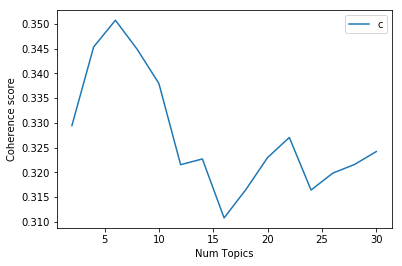

In [17]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

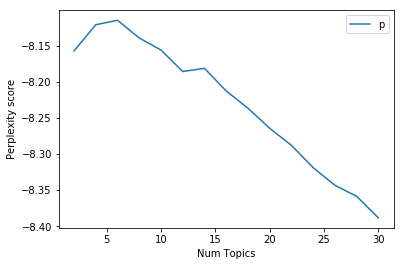

In [18]:
# Show graph
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [19]:
coherence_values

[0.32944633559203307,
 0.3453662593377023,
 0.35076784514058224,
 0.344899922496232,
 0.33797094629190577,
 0.32152050635830015,
 0.32267882392389075,
 0.3107419721577589,
 0.3164714035792329,
 0.32295960841783156,
 0.3270334503469321,
 0.3163855333861123,
 0.3198127041076995,
 0.32156403949456996,
 0.32417779787107937]

In [20]:
perplexity_values

[-8.157143988572216,
 -8.120919462361448,
 -8.114693388563559,
 -8.13933285143203,
 -8.155966899143127,
 -8.185673670270987,
 -8.181306462819103,
 -8.21273613754781,
 -8.236558267190347,
 -8.264313245568884,
 -8.288044862855092,
 -8.318846191210945,
 -8.343327026866179,
 -8.358591658408356,
 -8.388495272383873]

#### ------------------------ Kluster Topik yang Optimal ----------------------------------

## 14 Topik

In [22]:
lda14 = model_list[6]

In [23]:
words_topic = pd.DataFrame({i:[word for word, prob in lda14.show_topic(i, topn=30)] for i in range(0, lda14.num_topics)})
words_topic

0          1           2           3          4           5   \
0       mobil      motor     kendara       motor      mesin       mobil   
1   indonesia  indonesia   indonesia       honda      mobil   indonesia   
2     kendara     suzuki       mobil   indonesia   mercedes       pamer   
3       milik      mobil  mitsubishi       mobil     yamaha       giias   
4       model    kendara       motor     kendara      motor     kendara   
5        beli    jakarta         bmw       milik        bmw    otomotif   
6       motor         rp        jual         ban    hyundai      toyota   
7       honda     yamaha       honda        anak      hasil       motor   
8      nissan      jalan          pt       jalan      milik       jalan   
9        jual      milik       hadir       mesin     toyota    makassar   
10      mudik      mesin       sport    konsumen     desain        show   
11    jakarta         pt        unit     jakarta         js          rp   
12   konsumen   produksi      produk          pt      model        juta   
13      jalan      harga    konsumen     program  indonesia    industri   
14      mazda       juta      dealer  mitsubishi      jalan       honda   
15      harga       jual       model        jual       ubah       milik   
16      salah      hadir       milik       resmi     tenaga       mesin   
17      mesin      mudik       jalan       layan    kendara      unjung   
18         rp       unit    otomotif      produk   produksi        iims   
19    lebaran     produk       layan       pilih       benz       pasar   
20         pt       ribu     program       sedia      harga        auto   
21      pilih   konsumen      toyota       sport      class       harga   
22      pasar       jawa         new       model     varian        jual   
23     toyota      bahan       pasar        unit     tampil  mitsubishi   
24      hadir      salah      pajero        buka      cepat  selenggara   
25       unit      honda     tingkat         new      balap      produk   
26      orang      pilih     kembang       balap       unit       hadir   
27        bmw     sepeda       acara       harga      coupe    gaikindo   
28    tingkat   langsung     jakarta      tampil      liter          pt   
29    kembang      sport      motors   teknologi      ganti     jakarta   

           6          7          8          9          10         11  \
0       honda      honda      mobil    kendara      mobil      balap   
1       mesin      mobil      balap     suzuki      mesin         gp   
2       motor    kendara    kendara      jalan      jalan       moto   
3          rp      motor     toyota         rp      motor     yamaha   
4        juta      mesin      motor      mobil      milik       poin   
5       harga      milik      mesin  indonesia    kendara      motor   
6       milik     desain      milik       juta  indonesia      honda   
7   indonesia        new      jalan    jakarta      hasil      rossi   
8        part     tampil        ban      fitur      balap        tim   
9       model     toyota    ferrari     varian    listrik    lorenzo   
10   daihatsu  indonesia        tim      mesin      salah     suzuki   
11      hasil      balap  indonesia      motor        tim      hasil   
12      mobil    lengkap   mercedes      harga      bakar     ducati   
13        ktm         rp      model      lampu      bahan     posisi   
14      isuzu      sport      cepat      milik      cepat      juara   
15      balap      jalan      hasil  transmisi     tenaga      dunia   
16      pasar      fitur        rio      pilih      orang      jorge   
17     luncur        ban     sistem      warna        uji     menang   
18       baru      cepat        new    lengkap         id       team   
19       jual      lampu     posisi         km       kali    marquez   
20       nama      harga      harga        new      model    sirkuit   
21      mazda        all         gp      salah      dunia       marc   
22       beda       baru    j

In [24]:
words_topic.to_csv('Words/otomotif_kata_mei_14topik.csv')

In [25]:
pyLDAvis.enable_notebook()
train_vis_oto = pyLDAvis.gensim.prepare(lda14, corpus_bow, dictionary)
train_vis_oto

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      11.023944        1       1 -0.039476 -0.012194
1      10.119055        1       2 -0.021737 -0.024854
13      8.742699        1       3 -0.059798 -0.019933
10      8.662760        1       4  0.028133  0.004507
8       8.627607        1       5  0.031079  0.013945
11      7.117165        1       6  0.168808 -0.050870
12      7.071309        1       7 -0.027599 -0.011269
2       6.866408        1       8 -0.032254 -0.055221
9       6.721462        1       9 -0.032360  0.047639
7       6.573489        1      10  0.001336  0.033226
3       5.949156        1      11 -0.021228 -0.003101
5       5.526595        1      12 -0.052462 -0.036287
6       3.528623        1      13  0.030437  0.044053
4       3.469723        1      14  0.027120  0.070358, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
5     Default   6138.000000       balap   6138.000000  30.0000  30.0000
755   Default   8992.000000       honda   8992.000000  29.0000  29.0000
1769  Default   2626.000000          gp   2626.000000  28.0000  28.0000
177   Default  19774.000000       mobil  19774.000000  27.0000  27.0000
526   Default   4477.000000      suzuki   4477.000000  26.0000  26.0000
4226  Default   2498.000000        moto   2498.000000  25.0000  25.0000
450   Default   5683.000000          rp   5683.000000  24.0000  24.0000
237   Default   6413.000000        jual   6413.000000  23.0000  23.0000
466   Default   5273.000000        unit   5273.000000  22.0000  22.0000
428   Default   4456.000000        juta   4456.000000  21.0000  21.0000
252   Default   7829.000000       mesin   7829.000000  20.0000  20.0000
1274  Default   2468.000000  mitsubishi   2468.000000  19.0000  19.0000
4660  Default   3455.000000      yamaha   3455.000000  18.0000  18.0000
1251  Default   2206.000000      datsun   2206.000000  17.0000  17.0000
74    Default   1323.000000        poin   1323.000000  16.0000  16.0000
256   Default  12454.000000       motor  12454.000000  15.0000  15.0000
752   Default   1127.000000       giias   1127.000000  14.0000  14.0000
8592  Default   1196.000000       rossi   1196.000000  13.0000  13.0000
8646  Default    891.000000     lorenzo    891.000000  12.0000  12.0000
311   Default   2008.000000         bmw   2008.000000  11.0000  11.0000
764   Default   1784.000000       pamer   1784.000000  10.0000  10.0000
1089  Default   3999.000000         new   3999.000000   9.0000   9.0000
894   Default   5178.000000       harga   5178.000000   8.0000   8.0000
1250  Default   1174.000000    daihatsu   1174.000000   7.0000   7.0000
1273  Default   1494.000000    mercedes   1494.000000   6.0000   6.0000
290   Default   4061.000000      toyota   4061.000000   5.0000   5.0000
1510  Default   2322.000000         tim   2322.000000   4.0000   4.0000
40    Default  11324.000000   indonesia  11324.000000   3.0000   3.0000
2670  Default    668.000000    makassar    668.000000   2.0000   2.0000
160   Default   9936.000000     kendara   9936.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
3140  Topic14     59.516350        jeep    206.191284   2.1185  -6.6743
311   Topic14    216.981934         bmw   2008.374390   1.1358  -5.3807
7510  Topic14     72.390640          us    346.590515   1.7950  -6.4785
4660  Topic14    246.557922      yamaha   3455.136719   0.7211  -5.2529
252   Topic14    368.536499       mesin   7829.589844   0.3050  -4.8510
109   Topic14    171.962219        ubah   2021.607666   0.8967  -5.6133
233   Topic14     98.960121          hp    728.899292   1.3643  -6.1658
545   Topic14    185.141876      desain   2789.150635   0.6487  -5.5394
91    Topic14    112.680054        seri   1090.914551   1.0909  -6.0360
265   Topic14    162.609848    produksi   2406.509033   0.6665  -5.66

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.save_html(train_vis_oto, 'Vis Monthly/otomotif_mei_14topik.html')

## Label Artikel Berdasarkan Kluster yang Terbentuk

In [27]:
def predict_topic(test_data, dictionary, corpus, model):
    dictionary_model = gensim.corpora.Dictionary.load(dictionary)
    lda = gensim.models.LdaModel.load(model)
    doc_term_matrix = corpus.apply(lambda x: dictionary_model.doc2bow([d for d in x]))    
    test_data['predict_topic'] = doc_term_matrix.apply(lambda x: max(lda[x][0])[0])
    return test_data

In [38]:
predict_oto = predict_topic(data, dictionary='Dictionary/otomotif_mei.dict', corpus=data['tokenized'], model='Model Bulanan/otomotif_mei6_1539071590')

2018-10-09 15:13:28,267 : INFO : loading Dictionary object from Dictionary/otomotif_mei.dict
2018-10-09 15:13:28,307 : INFO : loaded Dictionary/otomotif_mei.dict
2018-10-09 15:13:28,307 : INFO : loading LdaModel object from Model Bulanan/otomotif_mei6_1539071590
2018-10-09 15:13:28,311 : INFO : loading expElogbeta from Model Bulanan/otomotif_mei6_1539071590.expElogbeta.npy with mmap=None
2018-10-09 15:13:28,315 : INFO : setting ignored attribute id2word to None
2018-10-09 15:13:28,319 : INFO : setting ignored attribute dispatcher to None
2018-10-09 15:13:28,319 : INFO : setting ignored attribute state to None
2018-10-09 15:13:28,319 : INFO : loaded Model Bulanan/otomotif_mei6_1539071590
2018-10-09 15:13:28,323 : INFO : loading LdaState object from Model Bulanan/otomotif_mei6_1539071590.state
2018-10-09 15:13:28,359 : INFO : loaded Model Bulanan/otomotif_mei6_1539071590.state


In [39]:
agustus = predict_oto.groupby('predict_topic')[['id']].count()
agustus.to_csv('Prediksi/mei_14topik.csv')

In [40]:
predict_oto.to_pickle('Prediksi/prediksi_otomotif_mei_14topik.pkl')

In [41]:
predict_oto.groupby('predict_topic')[['id']].count().sort_values(by='id')

id
predict_topic      
4               140
6               190
2               232
0               279
1               310
3               344
5               363
7               378
9               750
8               810
11             1251
12             1332
10             1593
13             1965

## 22 Topik

In [42]:
lda22 = model_list[10]

In [43]:
words_topic = pd.DataFrame({i:[word for word, prob in lda22.show_topic(i, topn=30)] for i in range(0, lda22.num_topics)})
words_topic

0          1           2           3          4           5   \
0       mobil      motor     kendara       motor     yamaha       mobil   
1   indonesia  indonesia   indonesia       honda      mesin       giias   
2     kendara     suzuki  mitsubishi   indonesia     toyota   indonesia   
3       milik    jakarta       mobil        anak    hyundai       pamer   
4       mazda    kendara       honda     kendara      motor     kendara   
5       motor      mobil       motor       mobil      hasil    otomotif   
6       honda     yamaha        jual       milik      mobil      toyota   
7      nissan         rp         bmw       mesin       ubah    makassar   
8       model      jalan          pt       jalan  indonesia        show   
9     jakarta      milik       hadir     jakarta      jalan       jalan   
10       beli         pt        unit  mitsubishi      milik    industri   
11      jalan   produksi      produk          pt      balap       motor   
12      salah      mesin       sport         ban        bmw        juta   
13       jual      harga    otomotif    konsumen      class          rp   
14      pasar       unit       jalan       sport   produksi       honda   
15         pt       juta      toyota       hadir   mercedes        auto   
16    lebaran      hadir       pasar     program    kendara       milik   
17   konsumen     produk       milik        unit       seri       mesin   
18      mesin       jual       model       pilih     desain    gaikindo   
19         rp       ribu      dealer      tampil      harga       pasar   
20      harga      salah    konsumen       acara      model      unjung   
21      mudik     sepeda     program       model     tenaga  selenggara   
22      hadir   langsung      safety        jual       kali       hadir   
23      pilih   konsumen     tingkat      sepeda     series  mitsubishi   
24    kembang     pabrik     kembang       balap      cepat       harga   
25    tingkat      honda     element         new     varian        iims   
26        suv      hasil      riding   teknologi       beda       sport   
27      bekas      bahan       acara        buka      sport     jakarta   
28       unit      mudik       layan      produk       benz      produk   
29        bmw       jawa     jakarta      yamaha     tampil         big   

           6          7          8          9     ...             12  \
0       mesin      honda      mobil    kendara    ...             rp   
1       honda      mobil      balap      jalan    ...           juta   
2       motor    kendara     toyota     suzuki    ...          motor   
3    daihatsu      motor    kendara  indonesia    ...          harga   
4        part      milik      motor    jakarta    ...          honda   
5       balap      balap      milik      fitur    ...          mobil   
6          rp     desain      mesin      motor    ...           jual   
7       milik      mesin      jalan      shell    ...      indonesia   
8        juta     tampil        tim         rp    ...            new   
9   indonesia     toyota        ban       juta    ...           unit   
10      isuzu        new        rio     varian    ...       kawasaki   
11      harga  indonesia  indonesia      mesin    ...          model   
12       team      jalan   mercedes      mobil    ...        jakarta   
13     racing    mugello    ferrari      lampu    ...         yamaha   
14      hasil      sport      hasil      harga    ...         nissan   
15        ktm      cepat    formula         km    ...       daihatsu   
16      mobil  komunitas      cepat    lengkap    ...          mesin   
17         gp         rp     posisi      pilih    ...            all   
18     yamaha        all      model      milik    ...          milik   
19       moto    lengkap    sirkuit      warna    ...             pt   
20      salah      lampu         gp       beda    ...          ninja   
21      jalan       kota    jakarta      salah    ...          hasil   
22       marc      fitur     

In [44]:
words_topic.to_csv('Words/otomotif_kata_mei_22topik.csv')

In [45]:
pyLDAvis.enable_notebook()
train_vis_oto = pyLDAvis.gensim.prepare(lda22, corpus_bow, dictionary)
train_vis_oto

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
15     8.120921        1       1 -0.026126 -0.014142
19     7.288843        1       2 -0.026249  0.052786
13     7.183510        1       3 -0.058215  0.045060
1      6.909908        1       4 -0.021802  0.034195
16     6.329730        1       5 -0.093357 -0.021929
11     6.132773        1       6  0.193670  0.063297
0      5.989968        1       7 -0.033730 -0.011105
8      5.700087        1       8  0.042035 -0.021966
10     5.302376        1       9  0.052857 -0.022561
2      5.273221        1      10 -0.027357 -0.003796
20     4.549002        1      11 -0.019920 -0.007054
5      4.165524        1      12 -0.054266  0.002180
12     3.987817        1      13 -0.015274  0.052051
9      3.836476        1      14 -0.033256  0.001455
17     3.741316        1      15 -0.028564  0.001167
3      3.343105        1      16 -0.019126  0.009598
7      3.081216        1      17  0.017649  0.008288
21     2.358273        1      18 -0.018509 -0.003444
18     2.204849        1      19 -0.018812 -0.057125
4      1.893052        1      20  0.038084 -0.018733
6      1.518080        1      21  0.068291  0.042699
14     1.089956        1      22  0.081980 -0.130921, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
177    Default  20495.000000       mobil  20495.000000  30.0000  30.0000
5      Default   5914.000000       balap   5914.000000  29.0000  29.0000
755    Default   8765.000000       honda   8765.000000  28.0000  28.0000
1251   Default   2004.000000      datsun   2004.000000  27.0000  27.0000
1769   Default   2596.000000          gp   2596.000000  26.0000  26.0000
450    Default   5899.000000          rp   5899.000000  25.0000  25.0000
4226   Default   2450.000000        moto   2450.000000  24.0000  24.0000
4660   Default   3443.000000      yamaha   3443.000000  23.0000  23.0000
466    Default   5307.000000        unit   5307.000000  22.0000  22.0000
237    Default   6662.000000        jual   6662.000000  21.0000  21.0000
526    Default   4734.000000      suzuki   4734.000000  20.0000  20.0000
256    Default  12718.000000       motor  12718.000000  19.0000  19.0000
45625  Default    646.000000          js    646.000000  18.0000  18.0000
252    Default   8123.000000       mesin   8123.000000  17.0000  17.0000
428    Default   4573.000000        juta   4573.000000  16.0000  16.0000
290    Default   3969.000000      toyota   3969.000000  15.0000  15.0000
633    Default    689.000000          id    689.000000  14.0000  14.0000
40     Default  11033.000000   indonesia  11033.000000  13.0000  13.0000
74     Default   1351.000000        poin   1351.000000  12.0000  12.0000
752    Default   1172.000000       giias   1172.000000  11.0000  11.0000
160    Default   9925.000000     kendara   9925.000000  10.0000  10.0000
894    Default   5277.000000       harga   5277.000000   9.0000   9.0000
1273   Default   1419.000000    mercedes   1419.000000   8.0000   8.0000
1089   Default   4029.000000         new   4029.000000   7.0000   7.0000
1886   Default   1246.000000          go   1246.000000   6.0000   6.0000
8646   Default    888.000000     lorenzo    888.000000   5.0000   5.0000
8592   Default   1165.000000       rossi   1165.000000   4.0000   4.0000
764    Default   1811.000000       pamer   1811.000000   3.0000   3.0000
1274   Default   2490.000000  mitsubishi   2490.000000   2.0000   2.0000
1510   Default   2196.000000         tim   2196.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
26604  Topic22     48.232292          if    111.916916   3.6773  -5.7267
41828  Topic22     47.373199        node    110.063225   3.6760  -5.7446
45632  Topic22     47.371300         var    110.983139   3.6677  -5.7447
45575  Topic22     47.386639      before    115.327682   

In [46]:
pyLDAvis.enable_notebook()
pyLDAvis.save_html(train_vis_oto, 'Vis Monthly/otomotif_mei_22topik.html')

In [53]:
predict_oto = predict_topic(data, dictionary='Dictionary/otomotif_mei.dict', corpus=data['tokenized'], model='Model Bulanan/otomotif_mei10_1539071590')

2018-10-09 15:20:28,900 : INFO : loading Dictionary object from Dictionary/otomotif_mei.dict
2018-10-09 15:20:28,937 : INFO : loaded Dictionary/otomotif_mei.dict
2018-10-09 15:20:28,941 : INFO : loading LdaModel object from Model Bulanan/otomotif_mei10_1539071590
2018-10-09 15:20:28,945 : INFO : loading expElogbeta from Model Bulanan/otomotif_mei10_1539071590.expElogbeta.npy with mmap=None
2018-10-09 15:20:28,973 : INFO : setting ignored attribute id2word to None
2018-10-09 15:20:28,977 : INFO : setting ignored attribute dispatcher to None
2018-10-09 15:20:28,977 : INFO : setting ignored attribute state to None
2018-10-09 15:20:28,977 : INFO : loaded Model Bulanan/otomotif_mei10_1539071590
2018-10-09 15:20:28,977 : INFO : loading LdaState object from Model Bulanan/otomotif_mei10_1539071590.state
2018-10-09 15:20:29,053 : INFO : loaded Model Bulanan/otomotif_mei10_1539071590.state


In [54]:
df = predict_oto.groupby('predict_topic')[['id']].count()
df.to_csv('Prediksi/mei_22topik.csv')

In [55]:
predict_oto.to_pickle('Prediksi/prediksi_otomotif_mei_22topik.pkl')

In [56]:
predict_oto.groupby('predict_topic')[['id']].count().sort_values(by='id')

id
predict_topic      
6                40
4                54
7                79
0                84
2                94
1                98
3               101
9               154
14              154
5               161
8               243
12              283
10              388
18              444
13              590
17              607
11              728
21              802
15              899
16             1021
20             1376
19             1537